In [177]:
import tensorflow as tf
import pandas as pd
import numpy as np
import xgboost
import sys

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline



sys.path.append("C:\\Users\\isvys\\Projects\\nnboost\\")
from nnboost import NNBoostClassifier

# Pre-defined functions

In [74]:
def num_cat_split(df):
    '''returns list of numerical and categorical columns'''
    
    num_col = list(df.select_dtypes(include=['number']).columns)
    cat_col = list(set(df.columns) - set(num_col))

    print(f"Numerical columns : \n{num_col}")
    print("")
    print(f"Categorical columns :\n {cat_col}")
    
    return num_col, cat_col


def cabin_letter(x):
    if isinstance(x, str):
        return x[0]
    else:
        return str(np.nan)
    
def featuring(DF):
    DF.drop(['Name','PassengerId'], axis=1, inplace=True)
    DF['Cabin'] = DF['Cabin'].apply(cabin_letter)
#     DF['Age'] = np.log(DF['Age'])
    DF['Embarked'] = DF['Embarked'].str.upper()
    DF['Fare'] = DF['Fare'].apply(lambda x : 100 if x >=100 else x)
    DF['Parch'] = DF['Parch'].apply(lambda x : 2 if x >= 2 else x)
    DF['SibSp'] = DF['SibSp'].apply(lambda x : 2 if x >= 2 else x)
    
#     DF['Parch'] = DF['Parch'].astype('category')
#     DF['SibSp'] = DF['SibSp'].astype('category')
#     DF['Pclass'] = DF['Pclass'].astype('category')
    
    return DF.copy()

# 1. Load Data

In [145]:
DF = pd.read_csv('datasets/titanic_train.csv')
DF

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [146]:
survived = DF.Survived==1
DF_sur = DF[survived]
DF_nonsur = DF[~survived]
DF_nonsur = DF_nonsur.iloc[:340]

In [147]:
DF = pd.concat([DF_sur, DF_nonsur], ignore_index=True)

In [148]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  682 non-null    int64  
 1   Survived     682 non-null    int64  
 2   Pclass       682 non-null    int64  
 3   Name         682 non-null    object 
 4   Sex          682 non-null    object 
 5   Age          552 non-null    float64
 6   SibSp        682 non-null    int64  
 7   Parch        682 non-null    int64  
 8   Ticket       682 non-null    object 
 9   Fare         682 non-null    float64
 10  Cabin        184 non-null    object 
 11  Embarked     680 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 64.1+ KB


# 2. N/A Columns

In [149]:
p = 0.7 # columns with more than 30 n/a rows 
df_rows = DF.shape[0]
na_freq = DF.isna().sum().sort_values(ascending=False) / df_rows
na_freq = na_freq[na_freq > 0.3]

In [150]:
na_columns = na_freq.index

In [151]:
na_num_col, na_cat_col = num_cat_split(DF[na_columns])

Numerical columns : 
[]

Categorical columns :
 ['Cabin']


In [152]:
DF.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,682.000000,682.000000,682.000000,552.000000,682.000000,682.000000,682.000000
mean,359.794721,0.501466,2.218475,29.414257,0.536657,0.392962,36.623301
std,228.185196,0.500365,0.860665,14.835739,1.053338,0.761294,55.147643
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,171.250000,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,341.500000,1.000000,3.000000,28.000000,0.000000,0.000000,16.100000
75%,511.750000,1.000000,3.000000,38.000000,1.000000,1.000000,35.500000
max,890.000000,1.000000,3.000000,80.000000,8.000000,5.000000,512.329200


# 3. Numerical Columns

In [153]:
num_col , _ = num_cat_split(DF)

Numerical columns : 
['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical columns :
 ['Embarked', 'Name', 'Sex', 'Ticket', 'Cabin']


In [154]:
DF.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,0.371998,-0.216868,0.035863,-0.083478,0.023973,0.145594
Survived,0.371998,1.000000,-0.312744,-0.075988,-0.060004,0.094858,0.214249
Pclass,-0.216868,-0.312744,1.000000,-0.389350,0.087529,-0.001236,-0.558275
Age,0.035863,-0.075988,-0.389350,1.000000,-0.296081,-0.251796,0.103190
SibSp,-0.083478,-0.060004,0.087529,-0.296081,1.000000,0.416002,0.130637
Parch,0.023973,0.094858,-0.001236,-0.251796,0.416002,1.000000,0.213253
Fare,0.145594,0.214249,-0.558275,0.103190,0.130637,0.213253,1.000000


[]

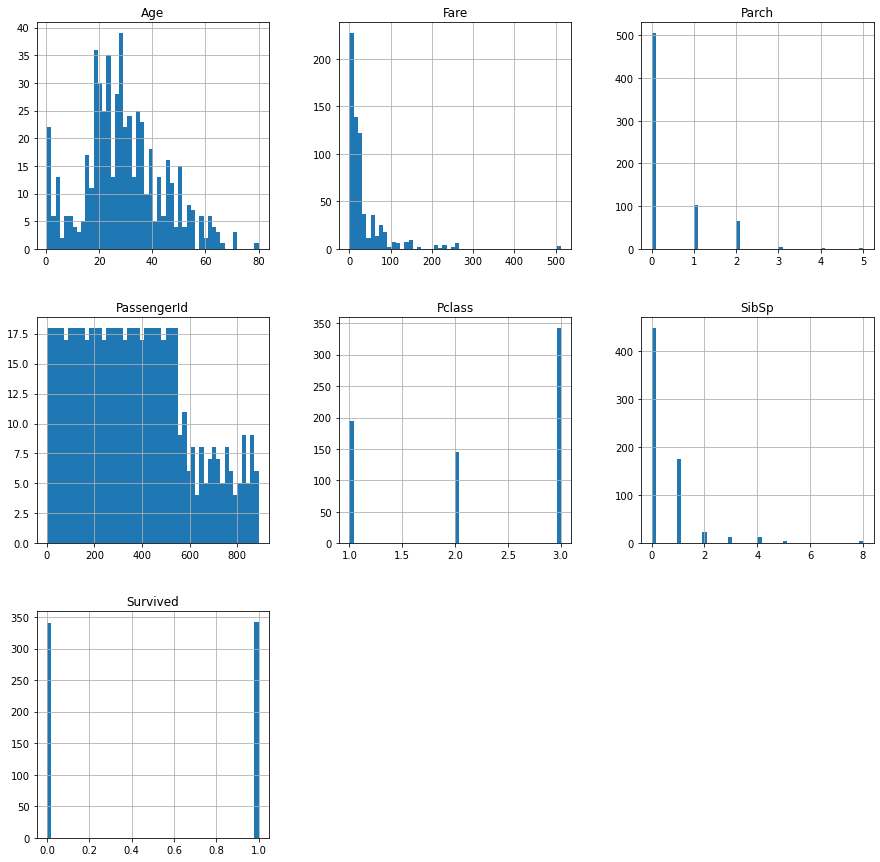

In [155]:
DF[num_col].hist(bins=50,figsize=(15,15))
plt.plot()

## 4. Categorical Columns

In [156]:
_ , cat_col = num_cat_split(DF)

Numerical columns : 
['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical columns :
 ['Embarked', 'Name', 'Sex', 'Ticket', 'Cabin']


In [157]:
DF = featuring(DF)

In [158]:
DF

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,female,38.0,1,0,PC 17599,71.2833,C,C
1,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,nan,S
2,1,1,female,35.0,1,0,113803,53.1000,C,S
3,1,3,female,27.0,0,2,347742,11.1333,nan,S
4,1,2,female,14.0,1,0,237736,30.0708,nan,C
...,...,...,...,...,...,...,...,...,...,...
677,0,2,male,27.0,0,0,244358,26.0000,nan,S
678,0,3,male,NaN,0,0,330979,7.8292,nan,Q
679,0,1,male,62.0,0,0,113807,26.5500,nan,S
680,0,1,male,NaN,0,0,PC 17757,100.0000,nan,C


In [159]:
X = DF.drop(['Survived'], axis=1).copy()
y = DF.Survived

In [178]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=77, stratify=y,)

In [179]:
num_col, cat_col = num_cat_split(X)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('numerical_imputer', SimpleImputer(strategy='median')),
    ('numerical_scaler', MinMaxScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('categorical_imputer', SimpleImputer(fill_value='NA', strategy='constant')),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, cat_col)
    ])


Numerical columns : 
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical columns :
 ['Sex', 'Ticket', 'Embarked', 'Cabin']


In [180]:
model = NNBoostClassifier(n_estimators=50, learning_rate=0.1,seed=123)
# model = xgboost.XGBClassifier(learning_rate=0.2)

In [181]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [182]:
my_pipeline.fit(X_train,y_train)

1.1460180282592773
NN #0 is done -> MAE : 0.01610620506107807
-4.294795036315918
NN #1 is done -> MAE : 0.028579263016581535
-17.14350128173828
NN #2 is done -> MAE : 0.014988141134381294
-14.936410903930664
NN #3 is done -> MAE : 0.013807687908411026
-9.884549140930176
NN #4 is done -> MAE : 0.013048321940004826
-15.925251960754395
NN #5 is done -> MAE : 0.019392605870962143
-7.349781036376953
NN #6 is done -> MAE : 0.017349228262901306
-74.72752380371094
NN #7 is done -> MAE : 0.044553108513355255
-31.066055297851562
NN #8 is done -> MAE : 0.012238774448633194
-26.94432830810547
NN #9 is done -> MAE : 0.014386300928890705
-40.06783676147461
NN #10 is done -> MAE : 0.011761116795241833
-27.809127807617188
NN #11 is done -> MAE : 0.012739317491650581
-33.988460540771484
NN #12 is done -> MAE : 0.014287183992564678
-34.10808563232422
NN #13 is done -> MAE : 0.013068344444036484
-29.250059127807617
NN #14 is done -> MAE : 0.014315984211862087
-33.63227844238281
NN #15 is done -> MAE : 0.

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('numerical_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                   

In [183]:
preds = my_pipeline.predict(X_valid)

In [184]:
preds

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1], dtype=int64)

In [185]:
print(classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83        68
           1       0.87      0.75      0.81        69

    accuracy                           0.82       137
   macro avg       0.82      0.82      0.82       137
weighted avg       0.82      0.82      0.82       137



In [168]:
y_valid.values

array([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0], dtype=int64)

In [169]:
# accuracy_score(y_valid, preds)

In [170]:
# plot_confusion_matrix(my_pipeline,
#                      X_valid,
#                      y_valid,
#                      values_format='d',
#                      display_labels=['Not Survived', 'Survived'])

In [71]:
X_test = pd.read_csv('datasets/titanic_test.csv')
Id = X_test['PassengerId']
X_test = featuring(X_test)
preds_test = my_pipeline.predict(X_test)
# Save test predictions to file
output = pd.DataFrame({'PassengerId': Id,
                       'Survived': preds_test})
output.to_csv('titanic_submission.csv', index=False)